# Lesson 5: Recurrent Neural Networks: Sequence Prediction

In this homework, you will create a *synthetic* dataset based on some simple mathematical functions. 

Then, you will design an RNN architecture that can read several function values in a row (*e.g.*, the values of the function at time points 0, 1, 2, 3, 4) and predict the next value (*e.g.*, the value of the function at time point 5).

First, though, our usual cast of imports.

In [1]:
%matplotlib inline

from keras.models import Model, Sequential
from keras.layers import LSTM, Dense
from keras.regularizers import l1_l2
from keras.regularizers import l2
import math
import numpy as np

import matplotlib.pyplot as plt

**NOTE:** If we haven't covered it fully at the time you start working on this assignment, we'll examine in detail what an *LSTM* is, and how one works, shortly.  For the purposes of the current assignment, you can think of an LSTM as a drop-in replacement for the units we've had in dense layers previously, but unlike those units, the LSTM has some built-in smarts that try to keep gradients flowing happily and overcome some of the ways that RNNs in particular make that problem difficult.

# Setting Up the Input Data for the Problem

In the next few cells, we'll build the data you're going to experiment with.

In [2]:
#Set up params for dataset.
NUM_FREQS = 2       # Number of sine waves to superimpose
SR = 200            # Digital sampling rate in samples per time unit
MAX_FREQ = SR / 2   # Nyquist frequency--if this is mysterious to you,
                    # don't worry about it... we just want to make sure
                    # any sinusoidal components in our signal aren't too
                    # high frequency to represent with fidelity when we
                    # look at a discretely sampled version of the signal.
two_pi = 2 * math.pi

MAX_FREQ /= 4  # Calm the frequencies down a little--pander to Nyquist above.

MAX_X_DATA = 5     # Set x-range from 0 to MAX_X_DATA

TRAIN_TEST_SPLIT = 0.7  # Percentage of data in training set

# Use this to try on random sine waves if you'd like, once you have things
# working.
RANDOMIZE_WAVES = False
if RANDOMIZE_WAVES:
    np.random.seed(42)
    freqs = np.random.rand(NUM_FREQS) * MAX_FREQ
    amplitudes = np.random.rand(NUM_FREQS)
    phases = np.random.rand(NUM_FREQS) * two_pi
    waves = list(zip(freqs, amplitudes, phases))
else:
    # Or just use fixed frequencies etc, to make it easier:
    waves = [(20, .5, 0), (3, .3, 3)]  # Each element is (freq, amplitude, phase)
waves

[(20, 0.5, 0), (3, 0.3, 3)]

If you read through the above you'll see that the function or signal we're planning to try and predict is made by taking two sine waves, each with different frequencies, amplitudes and phase lags, and adding them together. 

We'll visualize the result after we compute it.

In [3]:
# Make the sine wave data...
data = []
t_list = [float(i)/SR for i in range(SR * MAX_X_DATA)]
for t in t_list:
    total = 0
    for freq, A, phase in waves:
        total += A * np.sin(phase + t * freq * two_pi)
    data.append(total)

# normalize the amplitude of the resulting curve...
max_data = abs(np.max(data))
data /= max_data

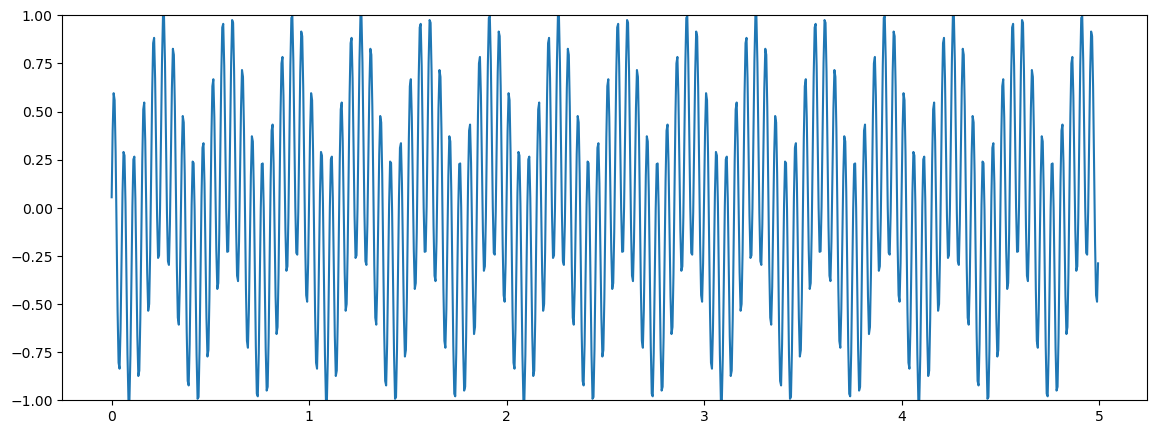

In [4]:
plt.figure(figsize=(14,5))
plt.ylim(-1,1)
plt.plot(t_list, data)
plt.show()

In [5]:
# Make input/output pairs: i.e. match data point at index (N) to data point at index (N+1)
#
# i.e. we want to create a sequence of pairs where each pair contains
#      a value of the function at some time, paired with its successor
#      value in the time sequence.
#
# If the 'zip' function is new to you, consult its Python documentation
# and play with it on a few examples.
#
data_pairs = list(zip(data, data[1:]))

In [6]:
# Have a look at what we've produced so far... I like to do this
# periodically to get a sense of the shapes and types of things as
# I work since Jupyter notebooks don't give you some of the affordances
# you'd expect from a full IDE...
print(f"len(data_pairs) = {len(data_pairs)}")
print(f"First five data_pairs = {data_pairs[:5]}")

len(data_pairs) = 999
First five data_pairs = [(0.054613123426684805, 0.397434783155069), (0.397434783155069, 0.5952831983193219), (0.5952831983193219, 0.5589840731103541), (0.5589840731103541, 0.28885960113327525), (0.28885960113327525, -0.12527439440585547)]


In [7]:
# Divide the data points into training and test sets
split_idx = int(len(data_pairs)*TRAIN_TEST_SPLIT )
train = data_pairs[:split_idx]
test = data_pairs[split_idx:]

# Now we'll splice apart the pairs that were grouped together a couple of
# cells above so that we'll have a sequence value x and its corresponding
# successor value y
train_x = np.array([x[0] for x in train])
train_y = np.array([x[1] for x in train])
# Do some reshaping:
train_x = np.reshape(train_x, (len(train_x), 1, 1))  # batch, #prev_context, #input nodes
train_y = np.reshape(train_y, (len(train_y), 1))     # batch, #prev_context, #output nodes

# Do the same steps for the data points in the test set...
test_x = np.array([x[0] for x in test])
test_y = np.array([x[1] for x in test])
test_x = np.reshape(test_x, (len(test_x), 1, 1))  # batch, #prev_context, #input nodes
test_y = np.reshape(test_y, (len(test_y), 1))     # batch, #prev_context, #output nodes

# Check the shapes of things
train_x.shape, train_y.shape, len(test)

((699, 1, 1), (699, 1), 300)

# Building and Experimenting with Different Models

The cell below contains an example model with a single recurrent layer
containing LSTM units, followed by a small fully connected layer with
ReLU activations and finally a linear activtion to produce the final
regression output.

Treat the model as starter code.  Run it and walk through the plots and
visualizations that follow it and get a sense for what they're doing to
try and help you measure how well your model is working.

How you manage the runs is up to you, but remember that Jupyter notebooks
are stateful, and the model object itself is stateful as well, so you may
want to create different models under different variable names and then
be careful about how you push the results through the *predicted vs. actual*
and *error* plots that are produced below.

When experimenting with this sort of thing by hand, I'll sometimes open
an Excel spreadsheet and use it to document model settings and parameters,
along with some comments while also trying to keep everything in the notebook
nicely named and separated and *easily reset to a known state*.  Also the
code to produce the plots could benefit from being packaged into reusable
functions.  Doing so is often fairly easy, and it's a good sort of hygienic
side task to do while experimenting with ML models in a notebook, especially
since notebooks can invite us to become pretty slovenly, which ultimately
can lead to errors, confusion and frustration.

Out of the gate, the starter model below should produce a result that's
reasonably credible. You should view the purpose of the exercise as understanding
the model's structure, what the model does, what the Keras code that creates the
model means, and what effects altering the architecture and changing regularization,
etc., have.  Throughout, work thoughtfully and keep notes on what you're doing.
Keep asking yourself whether a result seems reasonable or surprising, etc.

In [8]:
# Build LSTM model.

# The starter code below is just an example.  Tweak things to try
# and improve its performance.  You'll comment on what you did
# later in the notebook.

# TODO: You should produce some number of variations, say three to five,
# on this network, train them, and see how they perform.  You might try
# changing the number of units in the recurrent layer, making a fancier
# fully connected layer following it, trying different regularization
# parameters, etc.
#
NUM_LSTM_NODES = 15
NUM_EPOCHS = 10

model = Sequential()
model.add(LSTM(NUM_LSTM_NODES, 
               batch_input_shape=(1, 1, 1), 
               stateful=True, 
              kernel_regularizer=l1_l2(0)))
model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

# NOTE: We have no regularization in the starting example.
#       We've also set stateful on the LSTM units to be true,
#       so that the last state for each sample at index i in
#       a batch will be used as initial state for the sample
#       of index i in the following batch.  Now might be a
#       good time to review the Keras documentation on any
#       of the settings above that seem mysterious...

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (1, 15)                   1020      
                                                                 
 dense (Dense)               (1, 5)                    80        
                                                                 
 dense_1 (Dense)             (1, 1)                    6         
                                                                 
Total params: 1,106
Trainable params: 1,106
Non-trainable params: 0
_________________________________________________________________


In [9]:
# compile model
model.compile(loss='mse', optimizer='adam')

In [10]:
# fit() the model
#
# It's worth looking at the call to fit() itself, as well as anything
# else we're doing nearby, to make sure you feel comfortable with
# what it's doing...
def train_model(epochs, m):
    for i in range(epochs):
        print("Epoch %d" % i)
        m.fit(train_x, train_y, # training inputs and targets
              batch_size=1,
              epochs=1, 
              shuffle=False, # we don't want to shuffle, think about why? 
              verbose=1)
        # We reset the *hidden* states after each full pass through the training data...
        m.reset_states()

In [11]:
train_model(NUM_EPOCHS, model)

Epoch 0
699/699 [==============================] - 3s 2ms/step - loss: 0.1682
Epoch 1
699/699 [==============================] - 2s 3ms/step - loss: 0.0486
Epoch 2
699/699 [==============================] - 1s 2ms/step - loss: 0.0254
Epoch 3
699/699 [==============================] - 2s 3ms/step - loss: 0.0171
Epoch 4
699/699 [==============================] - 1s 2ms/step - loss: 0.0150
Epoch 5
699/699 [==============================] - 1s 2ms/step - loss: 0.0303
Epoch 6
699/699 [==============================] - 1s 2ms/step - loss: 0.0109
Epoch 7
699/699 [==============================] - 2s 2ms/step - loss: 0.0074
Epoch 8
699/699 [==============================] - 1s 2ms/step - loss: 0.0053
Epoch 9
699/699 [==============================] - 2s 2ms/step - loss: 0.0321


In [12]:
# Before we actually call model.evaluate() on the test set, it's worth
# reviewing the Keras documentation on just what evaluate() does, and
# what it returns. 
# See:
#    https://keras.io/api/models/model_training_apis/#evaluate-method
for m in model.metrics:
    print(m) # Remember which metrics we asked always get and
             # which we asked for...

Mean(name=loss,dtype=float32)


In [13]:
loss_on_test_set = model.evaluate(test_x, test_y, # test inputs and targets
                                  batch_size=1, verbose=0)
model.reset_states()
print(f"Model MSE Loss on Test Set: %f" % loss_on_test_set)

Model MSE Loss on Test Set: 0.032801


In [14]:
# Paste together our predictions alongside the corresponding
# training targets for comparison...
def plot_print_result(m):
    result = []
    for i in range(len(test_x)):
        prediction = m.predict(test_x[i].reshape(1,1,1), verbose=0)
        result.append([prediction, test_y[i]])

    predictions = [[x[0][0][0], x[1][0]] for x in result]

    # See how good our predictions did relative to the actual values.
    # As you experiment with things like different numbers of units
    # in the recurrent layer, or perhaps fancier fully connected stuff
    # after the recurrent layer, or types and amounts of regularization,
    # you can repeat this process---try to get a sense for how the knobs
    # you're turning are affecting things.
    plt.plot(predictions[50:150])
    plt.legend(('pred', 'actual'))
    plt.show()

    # test_y[:10]
    errors = [abs(x[1] - x[0]) for x in predictions]
    plt.plot(errors)
    plt.show()

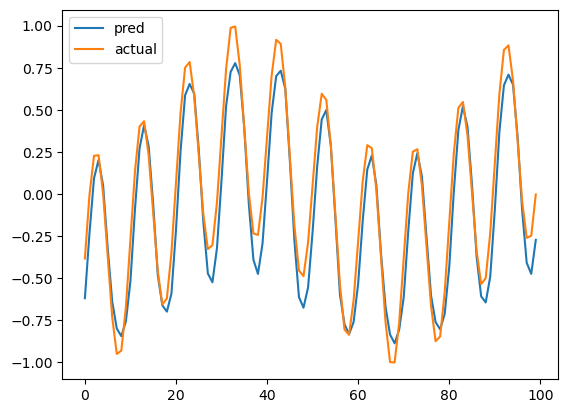

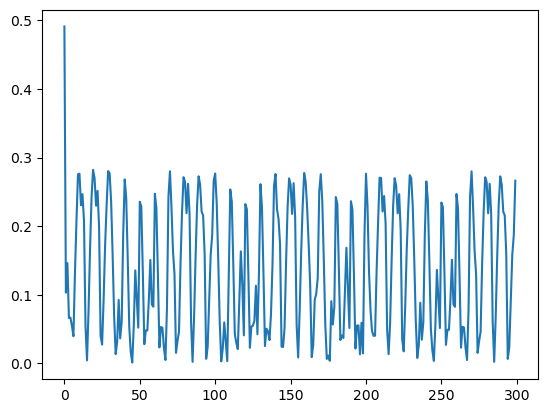

In [15]:
plot_print_result(model)

In [16]:
model.reset_states() # Clear (only!) the hidden states of the network

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (1, 8)                    320       
                                                                 
 dense_2 (Dense)             (1, 5)                    45        
                                                                 
 dense_3 (Dense)             (1, 1)                    6         
                                                                 
Total params: 371
Trainable params: 371
Non-trainable params: 0
_________________________________________________________________
None
Epoch 0
699/699 [==============================] - 3s 2ms/step - loss: 0.2461
Epoch 1
699/699 [==============================] - 2s 2ms/step - loss: 0.1379
Epoch 2
699/699 [==============================] - 2s 2ms/step - loss: 0.0767
Epoch 3
699/699 [==============================] - 1s 2ms/step - loss: 0.0494
Epo

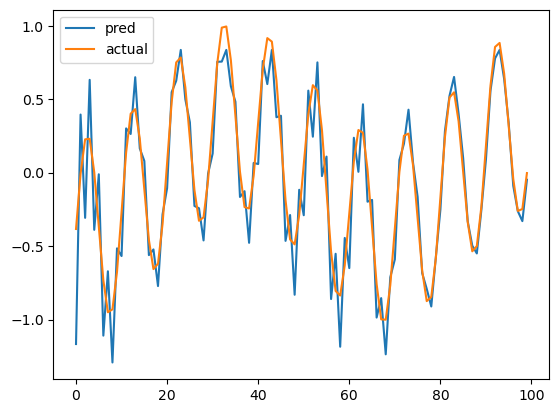

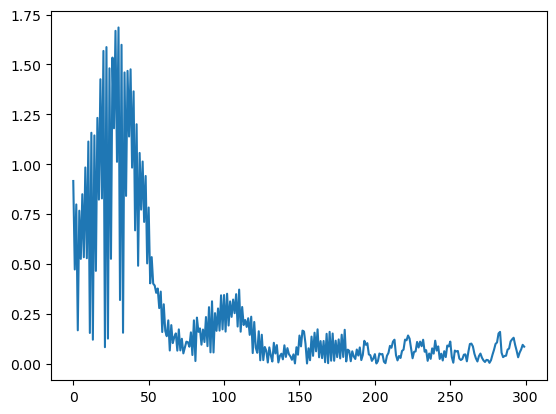

In [17]:
NUM_LSTM_NODES = 8
NUM_EPOCHS = 10

model_less_nodes = Sequential()
model_less_nodes.add(LSTM(NUM_LSTM_NODES, 
               batch_input_shape=(1, 1, 1), 
               stateful=True, 
              kernel_regularizer=l1_l2(0)))
model_less_nodes.add(Dense(5, activation='relu'))
model_less_nodes.add(Dense(1, activation='linear'))
print(model_less_nodes.summary())

model_less_nodes.compile(loss='mse', optimizer='adam')
train_model(NUM_EPOCHS, model_less_nodes)

loss_on_test_set = model_less_nodes.evaluate(test_x, test_y, # test inputs and targets
                                  batch_size=1, verbose=0)
model_less_nodes.reset_states()
print(f"Model MSE Loss on Test Set: %f" % loss_on_test_set)

plot_print_result(model_less_nodes)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (1, 8)                    320       
                                                                 
 dense_4 (Dense)             (1, 5)                    45        
                                                                 
 dense_5 (Dense)             (1, 1)                    6         
                                                                 
Total params: 371
Trainable params: 371
Non-trainable params: 0
_________________________________________________________________
None
Epoch 0
699/699 [==============================] - 4s 3ms/step - loss: 0.2617
Epoch 1
699/699 [==============================] - 1s 2ms/step - loss: 0.1512
Epoch 2
699/699 [==============================] - 2s 2ms/step - loss: 0.0686
Epoch 3
699/699 [==============================] - 2s 2ms/step - loss: 0.0327
Epo

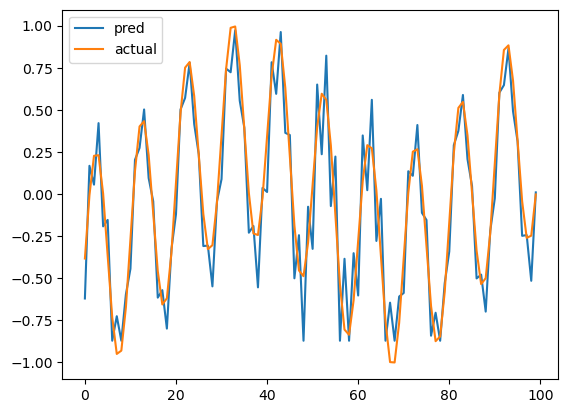

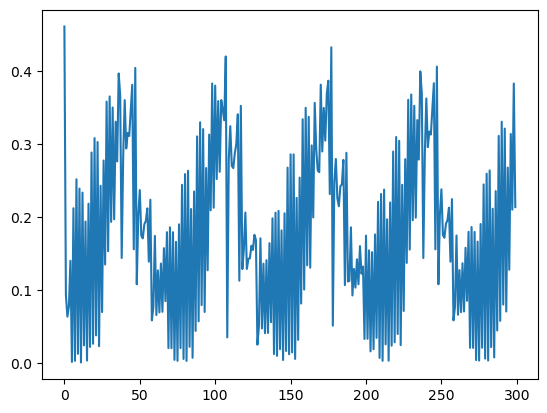

In [18]:
model_reg_ker = Sequential()
model_reg_ker.add(LSTM(NUM_LSTM_NODES, 
               batch_input_shape=(1, 1, 1), 
               stateful=True, 
              kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))
model_reg_ker.add(Dense(5, activation='relu'))
model_reg_ker.add(Dense(1, activation='linear'))
print(model_reg_ker.summary())

model_reg_ker.compile(loss='mse', optimizer='adam')
train_model(NUM_EPOCHS, model_reg_ker)

loss_on_test_set = model_reg_ker.evaluate(test_x, test_y, # test inputs and targets
                                  batch_size=1, verbose=0)
model_reg_ker.reset_states()
print(f"Model MSE Loss on Test Set: %f" % loss_on_test_set)

plot_print_result(model_reg_ker)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (1, 8)                    320       
                                                                 
 dense_6 (Dense)             (1, 5)                    45        
                                                                 
 dense_7 (Dense)             (1, 1)                    6         
                                                                 
Total params: 371
Trainable params: 371
Non-trainable params: 0
_________________________________________________________________
None
Epoch 0
699/699 [==============================] - 3s 2ms/step - loss: 0.1886
Epoch 1
699/699 [==============================] - 2s 2ms/step - loss: 0.0457
Epoch 2
699/699 [==============================] - 1s 2ms/step - loss: 0.0249
Epoch 3
699/699 [==============================] - 2s 2ms/step - loss: 0.0264
Epo

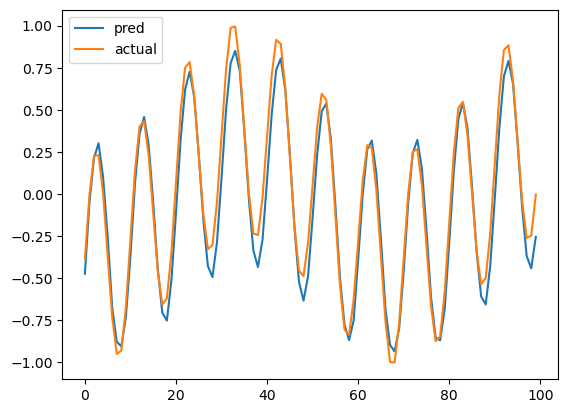

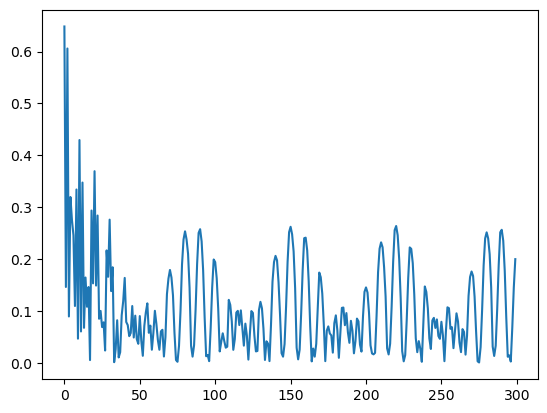

In [19]:
model_reg_rec = Sequential()
model_reg_rec.add(LSTM(NUM_LSTM_NODES, 
              batch_input_shape=(1, 1, 1), 
              stateful=True,
              activity_regularizer=l2(0.01),
              kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))
model_reg_rec.add(Dense(5, activation='relu'))
model_reg_rec.add(Dense(1, activation='linear'))
print(model_reg_rec.summary())

model_reg_rec.compile(loss='mse', optimizer='adam')
train_model(NUM_EPOCHS, model_reg_rec)

loss_on_test_set = model_reg_rec.evaluate(test_x, test_y, # test inputs and targets
                                  batch_size=1, verbose=0)
model_reg_rec.reset_states()
print(f"Model MSE Loss on Test Set: %f" % loss_on_test_set)

plot_print_result(model_reg_rec)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (1, 8)                    320       
                                                                 
 dense_12 (Dense)            (1, 5)                    45        
                                                                 
 dense_13 (Dense)            (1, 1)                    6         
                                                                 
Total params: 371
Trainable params: 371
Non-trainable params: 0
_________________________________________________________________
None
Epoch 0
699/699 [==============================] - 4s 2ms/step - loss: 0.1801
Epoch 1
699/699 [==============================] - 2s 2ms/step - loss: 0.0377
Epoch 2
699/699 [==============================] - 2s 2ms/step - loss: 0.0137
Epoch 3
699/699 [==============================] - 2s 2ms/step - loss: 0.0086
Epo

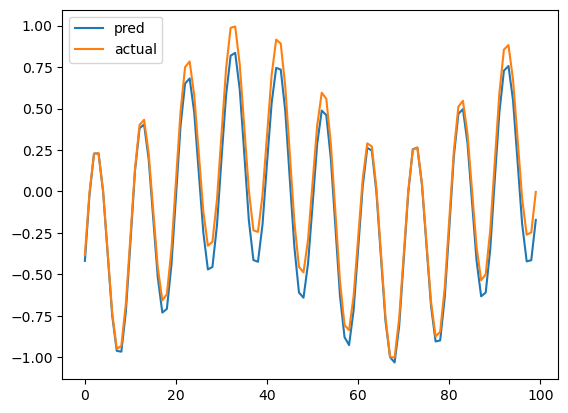

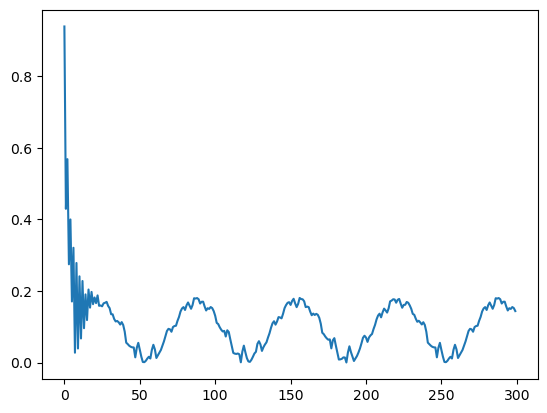

In [22]:
model_dense = Sequential()
model_dense.add(LSTM(NUM_LSTM_NODES, 
              batch_input_shape=(1, 1, 1), 
              stateful=True,
              activity_regularizer=l2(0.01),
              kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))
model_dense.add(Dense(5, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))
model_dense.add(Dense(1, activation='linear', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))
print(model_dense.summary())

model_dense.compile(loss='mse', optimizer='adam')
train_model(NUM_EPOCHS, model_dense)

loss_on_test_set = model_dense.evaluate(test_x, test_y, # test inputs and targets
                                  batch_size=1, verbose=0)
model_dense.reset_states()
print(f"Model MSE Loss on Test Set: %f" % loss_on_test_set)

plot_print_result(model_dense)

# Question 1:

**TODO**

- Describe the models you tried out, what motivated you to try each one, and discuss the results you obtained from each.
Tried 4 models all with some form of regularization because it helps with generalization and curbs bigger weights. My aim was to reduce the test loss metric. With each model, there is slight improvement/reduction in test loss of ~0.002.
1. The first is with lesser nodes (which is also another form of regularization) on the LSTM layer
2. The second is with kernel regularization on the LSTM layer
3. The third is with activity regularization on the LSTM layer
4. The fourth is with kernel regularization again on the Dense layer
- What sorts of changes and techniques did you try to improve your predictions?
  Could have probably tried adding another layer but given the simplistic nature of the data, made more sense to try and generalize the model more than add layers.
- What things did you find challenging or surprising?
  I'm not sure why the errors in the prediction error plots are see-sawing as much in model 2
- Which model worked best? How well would you say it worked?
  Models 3 and 4 have similar test losses and worked better than the rest

# Question 2:

**TODO**

- What problems did you run into?
  Using recurrent regularizer and not using bias seemed to worsen performance.

# Question 3:

**TODO**

When you think about it, the function we're trying to predict can be describe with *very few* parameters, assuming we have some notion of what a sinusoid is, and some notion of what sums of sinusoids are.  When we make our function by adding two sinusoids there is in some sense about six degrees of freedom to work with, namely the amplitudes, frequencies and phases of the two curves being added.  Thus if we were using an explicit representation where the process producing our input data distribution was literally summing sinusoids with those few selected parameters, we'd have a very good, very low dimensional representation, that *exactly* replicated what we were trying to predict.  This representation is not far from what you'd get from Fourier analysis (if you've seen that elsewhere) a tool widely used in signal processing, data analysis, data compression and many other applications.

Look at the number of parameters in the summaries of each of the models you produced.  In particular look at the one that did the best at producing a predicted curve that hugged the actual curve and look at the MSE that was associated with it.  What are your thoughts on how many parameters are in play here?

Remember: much of deep learning is about finding semi-automatic ways to find practical representations for real phenomena produced by some kind of process out in the world, where by practical we mean small enough to compute on, yet expressive enough to capture enough of the essence of the phenomena of interest that the representations can be made to do useful work for us.

I kept the model parameters the same when implementing new models. I was able to improve model metric without changing the number of parameters. But there is a possibility of overfitting with more parameters